### Run web-hosted BOPTEST simulation 

For running BOPTEST without the need of local downloads or installations, this simulation uses the BOPTEST  web-hosted environment (BOPTEST-Service). This publicly accessible service allows for the deployment of the test cases in the cloud, enabling interactions via the BOPTEST API. This notebook follows the steps outlined in [this](https://github.com/ibpsa/project1-boptest/blob/master/docs/workshops/BS21Workshop_20210831/Introduction_to_the_BOPTEST_framework.ipynb) BOPTEST tutorial.  

Prior to initiating the simulation, begin by importing the application and configuration files, and selecting the test case and simulation parameters.

### Import Application and Config file
Import application and its config file from the `singlezone_commercial_hydronic` interface based on the repository of currently available control stragegies:
- `testcase_interface_zone_temp_shed_price`
- `testcase_interface_zone_temp_shift_shed_price`

In [1]:
import sys
sys.path.append("..")
from testcase_interface_zone_temp_shift_shed_price import create_application
config_path = 'config_zone_temp.yml'

### Instantiate Application 
Instantiate the test case interface with shedding controls.

In [2]:
bt_interface = create_application(config_path)

### Selecting a Test Case and Simulation Parameters
We can select and launch a test case from the repository of [currently available test cases](https://ibpsa.github.io/project1-boptest/testcases/index.html). The simulation paramenters such as the scenario ones (time period and electricity price) can be chosen from the [test cases directory](https://github.com/ibpsa/project1-boptest/tree/master/testcases). Here we can also define the simulation step in seconds. 

In [3]:
# Select test case identifier 
testcase = 'singlezone_commercial_hydronic'

# Simulation parameters (choosen from https://github.com/ibpsa/project1-boptest/tree/master/testcases)
# scenario
time_period = 'peak_heat_day'
electricity_price ='dynamic'

# Set simulation step 
step = 900 # 15 min

### Launch the Selected Test Case
First, import the Python `requests` library so that we can make HTTP requests to the BOPTEST API at the address indicated by the `url`. Then, use the `POST /testcases/<test_case_name>/select` BOPTEST API endpoint to launch the test case and receive a corresponding `testid`. While the url is the common gateway for everyone to access the BOPTEST web-service, the `testid` is a unique identifier for you to address the test case that you have selected and launched.

In [4]:
import requests
url = "https://api.boptest.net"
testid = \
requests.post('{0}/testcases/{1}/select'.format(url,testcase)).json()['testid']


Once we have successfully obtained the `testid`, it is possible to start interacting with the selected test case using the rest of the BOPTEST API. For example, use the `GET /name` BOPTEST API endpoint, along with the testid, to request the name of the chosen test case.

In [5]:
# Get test case name
name = requests.get('{0}/name/{1}'.format(url, testid)).json()['payload']
print(name)

{'name': 'singlezone_commercial_hydronic'}


### Getting Control Input and Measurement Points
While control input and measurement points are described in the [documentation](https://ibpsa.github.io/project1-boptest/testcases/), they are also available to retreive from the BOPTEST API. This is especially useful to store for later when requesting data for a specific point.

Retrieve the control input and measurement outputs using the `GET /inputs` and `GET /measurements` BOPTEST API endpoints.

In [6]:
# Get inputs available
inputs = requests.get('{0}/inputs/{1}'.format(url, testid)).json()['payload']
print('TEST CASE INPUTS ---------------------------------------------')
print(inputs.keys())
# Get measurements available
measurements = requests.get('{0}/measurements/{1}'.format(url, testid)).json()['payload']
print('TEST CASE MEASUREMENTS ---------------------------------------')
print(measurements.keys())

TEST CASE INPUTS ---------------------------------------------
dict_keys(['oveValRad_activate', 'ahu_oveFanRet_activate', 'oveCO2ZonSet_activate', 'oveTZonSet_activate', 'ahu_oveFanSup_u', 'oveValCoi_u', 'ovePum_activate', 'ahu_oveFanRet_u', 'oveTSupSet_activate', 'oveTSupSet_u', 'ovePum_u', 'oveValCoi_activate', 'oveTZonSet_u', 'oveCO2ZonSet_u', 'ahu_oveFanSup_activate', 'oveValRad_u'])
TEST CASE MEASUREMENTS ---------------------------------------
dict_keys(['ahu_reaTRetAir_y', 'reaQHea_y', 'weaSta_reaWeaSolZen_y', 'reaOcc_y', 'reaPFan_y', 'weaSta_reaWeaHDirNor_y', 'ahu_reaPFanSup_y', 'weaSta_reaWeaNOpa_y', 'weaSta_reaWeaTBlaSky_y', 'weaSta_reaWeaNTot_y', 'weaSta_reaWeaSolAlt_y', 'reaTZon_y', 'weaSta_reaWeaLat_y', 'reaPEle_y', 'weaSta_reaWeaLon_y', 'ahu_reaTSupAir_y', 'weaSta_reaWeaSolTim_y', 'ahu_reaFloSupAir_y', 'weaSta_reaWeaCloTim_y', 'weaSta_reaWeaHGloHor_y', 'ahu_reaPFanRet_y', 'weaSta_reaWeaRelHum_y', 'weaSta_reaWeaHHorIR_y', 'weaSta_reaWeaSolDec_y', 'weaSta_reaWeaTDryBul_y', 

### Initializing a test scenario
Select a testing scenario using the `PUT /scenario` BOPTEST API endpoint to allow to test the  controller for a pre-defined period and with predefined conditions. It uses the parameters time_period and electricity_price to set a specific scenario as defined for each test case within their respective [documentation](https://github.com/ibpsa/project1-boptest/tree/master/testcases). 

In [7]:
scenario_return = requests.put('{0}/scenario/{1}'.format(url, testid),
    data={'time_period':time_period,
    'electricity_price':electricity_price}).json()['payload']

Setting the scenario API call can return the `time_period` as an argument with current time measurements of the simulation intialized to the scenario time period.
The variable `start_time_days` refers to the start time of the test period.

In [8]:
y = scenario_return['time_period']
start_time_days = y['time']/24/3600

### Get Forecast Data for Plotting BOPTEST comfort range

Use the `PUT /forecast` BOPTEST API endpoint with parameters point names referring to the list of forecast data needed, as well as horizon and interval in seconds to set a forecast horizon and data interval. This same endpoint is used to retrieve the forecast data, which will start from the current simulation time.

In [9]:
import pandas as pd
df_f_single_day = pd.DataFrame()
forecast_points = requests.get('{0}/forecast_points/{1}'.format(url, testid)).json()['payload']
list_forecast = list(forecast_points.keys())

# Get the forecast data for the specified point names and time horizon
f = requests.put('{0}/forecast/{1}'.format(url, testid), 
             data={'point_names': list_forecast, 'horizon':24*3600, 'interval':1*3600}).json()['payload']
# Create a dataframe from the forecast data
df_f_single_day = pd.DataFrame.from_dict(f)
    
# Set the index of the dataframe to the time field
df_f_single_day.set_index('time', inplace=True)
    
# Print the dataframe
print(df_f_single_day)

          winDir  TDewPoi  InternalGainsRad[1]  PriceElectricPowerConstant  \
time                                                                         
691200  6.283185   272.85           165.569630                     0.04281   
694800  6.283185   272.95           174.683543                     0.04281   
698400  0.174533   273.05           183.797463                     0.04281   
702000  0.174533   272.85           212.571425                     0.04281   
705600  0.174533   272.65           418.285706                     0.04281   
709200  0.523599   272.55           839.272745                     0.04281   
712800  0.523599   272.05          4943.999840                     0.04281   
716400  0.523599   271.65         18191.999200                     0.04281   
720000  0.349066   271.45         21840.000300                     0.04281   
723600  0.349066   270.75         24335.999800                     0.04281   
727200  0.349066   270.65         25536.000050                  

### Simulating the Baseline Control for Benchmarking
Before testing a new controller, we need to simulate the baseline for a defined scenario and evaluate its performance. The baseline can be quickly simulated by setting a long control step and without overwritting any control signal when advancing the simulation. Here, we even set the control step to one year knowing that the simulation is forced to stop at the end of the scenario time period.

In [10]:
# Set the control step to one year 
requests.put('{0}/step/{1}'.format(url, testid), data={'step':365*24*3600})

# Advance the simulation with no control overwrite
requests.post('{0}/advance/{1}'.format(url, testid), data={}).json()

{'status': 200,
 'message': 'Advanced simulation successfully from 691200.0s to 1900800.0s.',
 'payload': {'ahu_reaTRetAir_y': 294.14835307724854,
  'reaQHea_y': 49404.02201286962,
  'reaOcc_y': 2.4917127071823204,
  'reaPFan_y': 0,
  'ovePum_activate': 0,
  'oveTZonSet_u': 288.15,
  'oveValCoi_activate': 0,
  'ahu_reaPFanSup_y': 0,
  'weaSta_reaWeaNOpa_y': 0.5,
  'weaSta_reaWeaTBlaSky_y': 256.3442289597479,
  'weaSta_reaWeaNTot_y': 0.6000000000000001,
  'weaSta_reaWeaSolAlt_y': -0.9420669107812976,
  'ahu_oveFanRet_activate': 0,
  'reaTZon_y': 288.14973406550445,
  'weaSta_reaWeaSolZen_y': 2.512863237576194,
  'reaPEle_y': 224.9952390737558,
  'weaSta_reaWeaHHorIR_y': 245,
  'ahu_reaTSupAir_y': 294.1803010406434,
  'weaSta_reaWeaSolTim_y': 1899535.014959388,
  'oveValCoi_u': 0,
  'ahu_reaFloSupAir_y': 1.793662034335766e-43,
  'oveCO2ZonSet_u': 800,
  'weaSta_reaWeaCloTim_y': 1900800,
  'weaSta_reaWeaLon_y': 0.22113321622768156,
  'weaSta_reaWeaHDifHor_y': 0,
  'oveValRad_activate': 0,

### Getting Core KPI Values
To obtain the KPI, calculated based on the emulator performance during a simulation (starting from the initialization), use the `GET /kpi` BOPTEST API endpoint.

The core KPIs, those that are calculated for every test case, are defined in BOPTEST to evaluate different aspects of a controller. These are:

- **Thermal discomfort**: reported with units of [Kh/zone], defines the cumulative deviation of zone temperatures from upper and lower comfort limits that are predefined within the test case FMU for each zone, averaged over all zones. Air temperature is used for air-based systems and operative temperature is used for radiant systems.

- **Indoor Air Quality (IAQ) Discomfort**: reported with units of [ppmh/zone], defines the extent that the CO
 concentration levels in zones exceed bounds of the acceptable concentration level, which are predefined within the test case FMU for each zone, averaged over all zones.

- **Energy Use**: reported with units of [kWh/m2], defines the HVAC energy usage.

- **Peak electrical demand**:reported with units of [kW/m2], defines the HVAC peak electrical demand.

- **Peak gas demand**:reported with units of [kW/m2], defines the HVAC peak gas demand.

- **Peak district heating demand**:reported with units of [kW/m2], defines the HVAC peak district heating demand.

- **Cost**: reported with units of [USD/m2] or [EUR/m2], defines the operational cost associated with the HVAC energy usage.

- **Emissions**: reported with units of [kgCO2/m2], defines the CO2 emissions from the HVAC energy usage.

- **Computational time ratio**: defines the average ratio between the controller computation time and the test simulation control step. The controller computation time is measured as the time between two emulator advances.

The warmup period is not taken into account for the calculation of the KPIs.


In [11]:
kpis_bas = requests.get('{0}/kpi/{1}'.format(url, testid)).json()['payload']
kpis_bas

{'tdis_tot': 7.995196440046154,
 'idis_tot': 5.4233567964530875,
 'ener_tot': 3.21679064412143,
 'cost_tot': 0.2631871664128049,
 'emis_tot': 0.3835809336421568,
 'pele_tot': 0.004907824412797784,
 'pgas_tot': None,
 'pdih_tot': 0.08966822552694508,
 'time_rat': None}

### Export Baseline Results

In [12]:
# Export baseline results
import numpy as np

list_measurement = ['ahu_reaPFanRet_y','ahu_reaPFanSup_y', 'reaPEle_y', 'reaPFan_y', 'reaPPum_y']

df_bas_epower = pd.DataFrame()
for point in list_measurement:
        args = {'point_names':point,
                'start_time':start_time_days*24*3600, 
                'final_time':np.inf}
        bas = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_bas_epower = pd.concat((df_bas_epower,pd.DataFrame(data=bas[point], 
                            index=bas['time'],columns=[point])), axis=1)
df_bas_epower.index.name = 'time'

# Export DataFrame to CSV file
csv_filepower_path = 'baseline_powerData.csv'
df_bas_epower.to_csv(csv_filepower_path)

csv_fileschedule_path = 'scheduleData.csv'
df_f_single_day.to_csv(csv_fileschedule_path)


list_heat_measurement = ['reaQHea_y']

df_bas_hpower = pd.DataFrame()
for hpoint in list_heat_measurement:
        args = {'point_names':hpoint,
                'start_time':start_time_days*24*3600, 
                'final_time':np.inf}
        bas_hpower = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_bas_hpower = pd.concat((df_bas_hpower,pd.DataFrame(data=bas_hpower[hpoint], 
                            index=bas_hpower['time'],columns=[hpoint])), axis=1)
df_bas_hpower.index.name = 'time'

# Export DataFrame to CSV file
csv_fileHpower_path = 'baseline_HpowerData.csv'
df_bas_hpower.to_csv(csv_fileHpower_path)


list_temp_measurement = ['oveTZonSet_u', 'reaTZon_y']

df_bas_temp = pd.DataFrame()
for tpoint in list_temp_measurement:
        args = {'point_names':tpoint,
                'start_time':start_time_days*24*3600, 
                'final_time':start_time_days*24*3600 + 24*3600}
        bas_temp = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_bas_temp = pd.concat((df_bas_temp,pd.DataFrame(data=bas_temp[tpoint], 
                            index=bas_temp['time'],columns=[tpoint])), axis=1)
df_bas_temp.index.name = 'time'

# Export DataFrame to CSV file
csv_fileTemp_path = 'baseline_tempData.csv'
df_bas_temp.to_csv(csv_fileTemp_path)


print("Baseline data has been exported to data.csv successfully.")

Baseline data has been exported to data.csv successfully.


### Getting Simulation Result from Baseline
The simulation results can be obtained with the `GET /results` BOPTEST API endpoint and `point_name`, `start_time`, and `final_time parameters`, which are used to define the point and time period of data to be retrieved. The start and final times need to be defined in seconds from the start of the year. In the code below, we use negative and positive infinity to collect all available data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


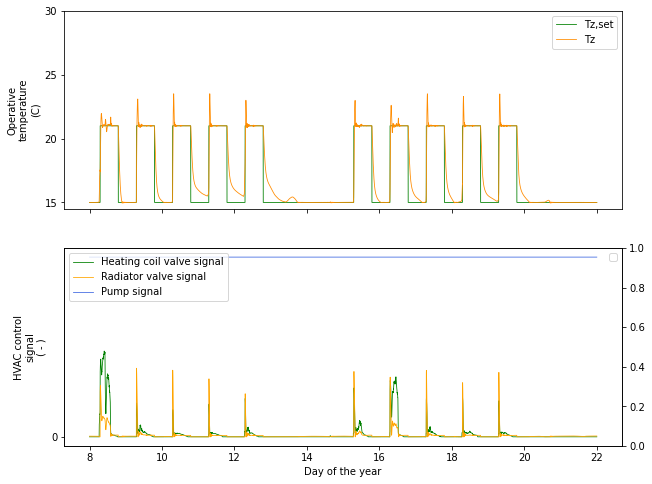

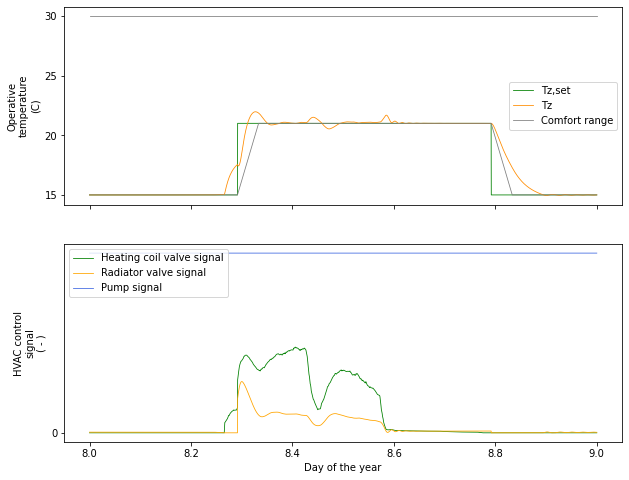

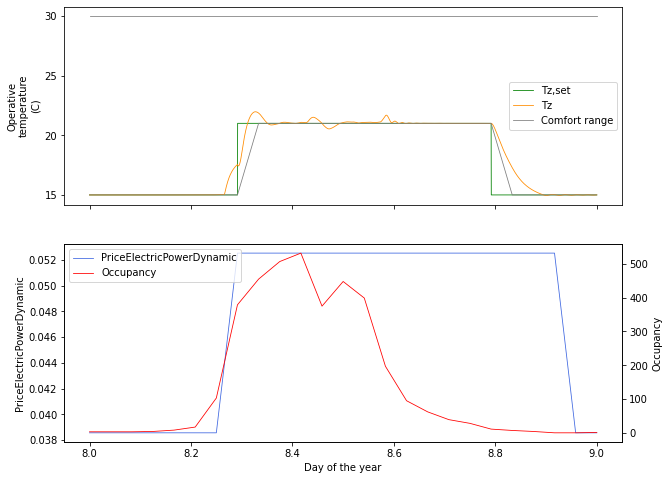

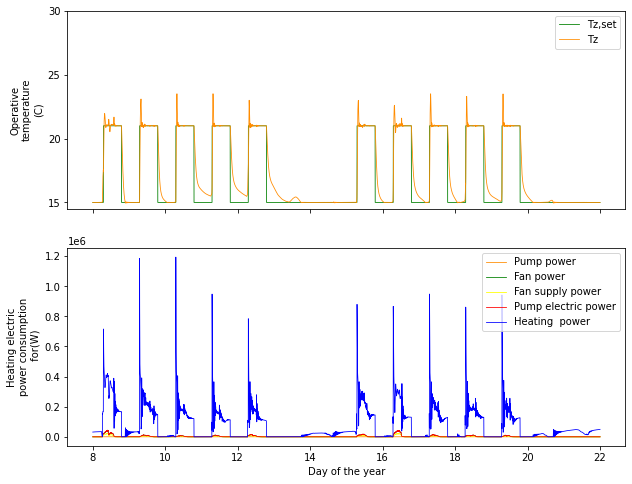

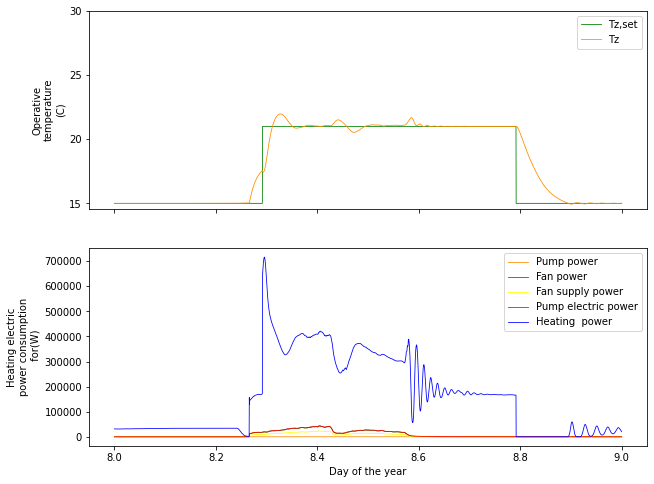

In [13]:
# (optional)
# Time series visualization of the results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def get_and_plot_results_scenario(testid, start_time, final_time):
    '''
    Get and plot result key trajectories from the test case.

    The key trajectories are zone operative temperature and setpoint, 
    and heating coil valve, radiator valve and pump modulating signal.

    Parameters
    ----------
    testid : str
      The testid for the test case.
    start_time : float or int
      The start time in seconds from the beginning of the year for data.
    final_time : float or int
      The final time in seconds from the beginning of the year for data.

    Returns
    -------
    None

    '''

    list_measurement = ['reaTZon_y', 'ovePum_u','oveTZonSet_u','oveValCoi_u', 'oveValRad_u']

    df_res = pd.DataFrame()
    for point in list_measurement:
        args = {'point_names':point,
                'start_time':start_time, 
                'final_time':final_time}
        res = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_res = pd.concat((df_res,pd.DataFrame(data=res[point], 
                            index=res['time'],columns=[point])), axis=1)
    df_res.index.name = 'time'
    plt.close()
    _, axs = plt.subplots(2, sharex=True, figsize=(10,8))
    x_time = df_res.index/3600./24.
    
    # Plot operative temperature
    axs[0].plot(x_time, df_res['oveTZonSet_u']    - 273.15, 'green', 
                linestyle='-', linewidth=0.8, label='Tz,set') 
    axs[0].plot(x_time, df_res['reaTZon_y']    - 273.15, 'darkorange', 
                linestyle='-', linewidth=0.8, label='Tz')
    axs[0].set_yticks(np.arange(15, 31, 5))
    axs[0].set_ylabel('Operative\ntemperature\n(C)')
    axs[0].legend()
    
        
    # Plot heat pump power 
    axs[1].plot(x_time, df_res['oveValCoi_u'], 'green', 
                linestyle='-', linewidth=0.8, label='Heating coil valve signal')
    axs[1].plot(x_time, df_res['oveValRad_u'], 'orange', 
                linestyle='-', linewidth=0.8, label='Radiator valve signal')
    axs[1].plot(x_time, df_res['ovePum_u'], 'royalblue', 
                linestyle='-', linewidth=0.8, label='Pump signal')
    axs[1].set_ylabel('HVAC control\nsignal\n( - )')
    axs[1].set_yticks(np.arange(0, 1, 1))
    axs[1].legend(loc='upper left')
    axs[1].set_xlabel('Day of the year')
    axt = axs[1].twinx()
    
    axt.legend(loc='upper right')
    plt.show()  

    return None


def get_and_plot_results_single_day(testid, start_time, final_time, df_f_single_day):
    '''
    Get and plot result key trajectories from the test case.

    The key trajectories are zone operative temperature and setpoint, comfort range, and 
    heating coil valve, radiator valve and pump modulating signal.

    Parameters
    ----------
    testid : str
      The testid for the test case.
    start_time : float or int
      The start time in seconds from the beginning of the year for data.
    final_time : float or int
      The final time in seconds from the beginning of the year for data.
    df_f_single_day : df
      Forecast dataframe for selected points.
    Returns
    -------
    None

    '''

    list_measurement = ['reaTZon_y', 'ovePum_u','oveTZonSet_u','oveValCoi_u', 'oveValRad_u']

    df_res = pd.DataFrame()
    for point in list_measurement:
        args = {'point_names':point,
                'start_time':start_time, 
                'final_time':final_time}
        res = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_res = pd.concat((df_res,pd.DataFrame(data=res[point], 
                            index=res['time'],columns=[point])), axis=1)
    
    plt.close()
    _, axs = plt.subplots(2, sharex=True, figsize=(10,8))
    x_time = df_res.index/3600./24.
    xf_time = df_f_single_day.index/3600./24.
   
     # Plot operative temperature
    axs[0].plot(x_time, df_res['oveTZonSet_u']    - 273.15, 'green', 
                linestyle='-', linewidth=0.8, label='Tz,set') 
    axs[0].plot(x_time, df_res['reaTZon_y']    - 273.15, 'darkorange', 
                linestyle='-', linewidth=0.8, label='Tz')
    axs[0].plot(xf_time, df_f_single_day['LowerSetp[1]'] - 273.15, 'gray', 
                linestyle='-', linewidth=0.8, label='Comfort range')
    axs[0].plot(xf_time, df_f_single_day['UpperSetp[1]'] - 273.15, 'gray', 
                linestyle='-', linewidth=0.8, label='_nolegend_')
    axs[0].set_yticks(np.arange(15, 31, 5))
    axs[0].set_ylabel('Operative\ntemperature\n(C)')
    axs[0].legend()


     # Plot heat pump modulating signal
    axs[1].plot(x_time, df_res['oveValCoi_u'], 'green', 
                linestyle='-', linewidth=0.8, label='Heating coil valve signal')
    axs[1].plot(x_time, df_res['oveValRad_u'], 'orange', 
                linestyle='-', linewidth=0.8, label='Radiator valve signal')
    axs[1].plot(x_time, df_res['ovePum_u'], 'royalblue', 
                linestyle='-', linewidth=0.8, label='Pump signal')
    axs[1].set_ylabel('HVAC control\nsignal\n( - )')
    axs[1].set_yticks(np.arange(0, 1, 1))
    axs[1].legend(loc='upper left')
    axs[1].set_xlabel('Day of the year')

    plt.show()

    return None

# %% (optional)
# Print baseline control results
# For the scenario period 
get_and_plot_results_scenario(testid, start_time=start_time_days*24*3600, final_time=np.inf)
# For a single day
get_and_plot_results_single_day(testid, start_time=start_time_days*24*3600, final_time=start_time_days*24*3600 + 24*3600, df_f_single_day = df_f_single_day)



def get_and_plot_results_single_day_price_occ(testid, start_time, final_time, df_f_single_day):
    '''
    Get and plot result key trajectories from the test case.

    The key trajectories are zone operative temperature and setpoint, comfort range, and 
    heating coil valve, radiator valve and pump modulating signal.

    Parameters
    ----------
    testid : str
      The testid for the test case.
    start_time : float or int
      The start time in seconds from the beginning of the year for data.
    final_time : float or int
      The final time in seconds from the beginning of the year for data.
    df_f_single_day : df
      Forecast dataframe for selected points.
    Returns
    -------
    None

    '''

    list_measurement = ['reaTZon_y', 'ovePum_u','oveTZonSet_u','oveValCoi_u', 'oveValRad_u']

    df_res = pd.DataFrame()
    for point in list_measurement:
        args = {'point_names':point,
                'start_time':start_time, 
                'final_time':final_time}
        res = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_res = pd.concat((df_res,pd.DataFrame(data=res[point], 
                            index=res['time'],columns=[point])), axis=1)
    
    plt.close()
    _, axs = plt.subplots(2, sharex=True, figsize=(10,8))
    x_time = df_res.index/3600./24.
    xf_time = df_f_single_day.index/3600./24.
   
     # Plot operative temperature
    axs[0].plot(x_time, df_res['oveTZonSet_u']    - 273.15, 'green', 
                linestyle='-', linewidth=0.8, label='Tz,set') 
    axs[0].plot(x_time, df_res['reaTZon_y']    - 273.15, 'darkorange', 
                linestyle='-', linewidth=0.8, label='Tz')
    axs[0].plot(xf_time, df_f_single_day['LowerSetp[1]'] - 273.15, 'gray', 
                linestyle='-', linewidth=0.8, label='Comfort range')
    axs[0].plot(xf_time, df_f_single_day['UpperSetp[1]'] - 273.15, 'gray', 
                linestyle='-', linewidth=0.8, label='_nolegend_')
    axs[0].set_yticks(np.arange(15, 31, 5))
    axs[0].set_ylabel('Operative\ntemperature\n(C)')
    axs[0].legend()


    # Plot price and occupancy schedules
    axs[1].plot(xf_time, df_f_single_day['PriceElectricPowerDynamic'], 'royalblue', 
                linestyle='-', linewidth=0.8, label='PriceElectricPowerDynamic') 
    axs[1].set_ylabel('PriceElectricPowerDynamic')

    # Add secondary y-axis 
    axs_occ = axs[1].twinx()
    axs_occ.plot(xf_time, df_f_single_day['Occupancy[1]'], 'red', 
                linestyle='-', linewidth=0.8, label='Occupancy') 
    axs_occ.set_ylabel('Occupancy')

    # Combine the legends of both axes
    lines1, labels1 = axs[1].get_legend_handles_labels()  
    lines2, labels2 = axs_occ.get_legend_handles_labels()
    axs[1].legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    axs[1].set_xlabel('Day of the year')

    plt.show()

    return None

# %% (optional)
# Print baseline control results
# For a single day price
get_and_plot_results_single_day_price_occ(testid, start_time=start_time_days*24*3600, final_time=start_time_days*24*3600 + 24*3600, df_f_single_day = df_f_single_day)



# %% (optional)
# Print electric power consumption
# Time series visualization of the results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_and_plot_demand_results(testid, start_time, final_time):
    '''
    Get and plot result key trajectories from the test case.

    The key trajectories are zone operative temperature, zone heating and 
    cooling set points, heating and cooling equipment electrical consumption.

    Parameters
    ----------
    testid : str
      The testid for the test case.
    start_time : float or int
      The start time in seconds from the beginning of the year for data.
    final_time : float or int
      The final time in seconds from the beginning of the year for data.

    Returns
    -------
    None

    '''

    df_res = pd.DataFrame()
    for point in ['reaTZon_y','oveTZonSet_u','reaPPum_y','reaPFan_y', 'ahu_reaPFanRet_y',
                  'ahu_reaPFanSup_y', 'reaPEle_y', 'reaQHea_y']:
        args = {'point_names':point,
                'start_time':start_time, 
                'final_time':final_time}
        res = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        #print(point, ": ", res)
        df_res = pd.concat((df_res,pd.DataFrame(data=res[point], 
                            index=res['time'],columns=[point])), axis=1)
    df_res.index.name = 'time'
    plt.close()
    _, axs = plt.subplots(2, sharex=True, figsize=(10,8))
    x_time = df_res.index/3600./24.
    
    # Plot operative temperature
    axs[0].plot(x_time, df_res['oveTZonSet_u']    - 273.15, 'green', 
                linestyle='-', linewidth=0.8, label='Tz,set') 
    axs[0].plot(x_time, df_res['reaTZon_y']    - 273.15, 'darkorange', 
                linestyle='-', linewidth=0.8, label='Tz')
    axs[0].set_yticks(np.arange(15, 31, 5))
    axs[0].set_ylabel('Operative\ntemperature\n(C)')
    axs[0].legend()

     # Plot electric power for heating
    axs[1].plot(x_time, df_res['reaPPum_y'], 'darkorange', 
                linestyle='-', linewidth=0.8, label='Pump power')                 
    axs[1].plot(x_time, df_res['reaPFan_y'], 'green', 
                linestyle='-', linewidth=0.8, label='Fan power')
                   
    axs[1].plot(x_time, df_res['ahu_reaPFanSup_y'], 'yellow', 
                linestyle='-', linewidth=0.8, label='Fan supply power')   
                   
    axs[1].plot(x_time, df_res['reaPEle_y'], 'red', 
                linestyle='-', linewidth=0.8, label='Pump electric power')   
                   
    axs[1].plot(x_time, df_res['reaQHea_y'], 'blue', 
                linestyle='-', linewidth=0.8, label='Heating  power')       
    axs[1].set_ylabel('Heating electric\npower consumption\n for(W)')
    axs[1].legend()


    axs[1].set_xlabel('Day of the year')

    plt.show()  

    return None

# %% (optional)
# Print baseline demand results
# For the scenario period 
get_and_plot_demand_results(testid, start_time=start_time_days*24*3600, final_time=np.inf)
# For a single day
get_and_plot_demand_results(testid, start_time=start_time_days*24*3600, final_time=start_time_days*24*3600 + 24*3600)


### Assessing a New Control Strategy
For assessing a new control strategy, we need to initialize the test case in the same scenario used to obtain the baseline controller KPIs, and here we obtain the control step as defined in the setting simulation parameters part. After that, we instantiate the controller and define a simulation loop using the BOPTEST API. Note that the test case will return an empty dictionary when the testing period has elapsed, such that we can loop over the returned measurements without having to infer when the simulation time should end.

In [14]:
import json

# Initialize scenario
y = requests.put('{0}/scenario/{1}'.format(url, testid), 
                 data={'time_period': time_period,
                       'electricity_price':electricity_price}).json()['payload']['time_period']

# Set control step
requests.put('{0}/step/{1}'.format(url, testid), data={'step':step})

# Get step
s = requests.get('{0}/step/{1}'.format(url, testid)).json()['payload']

# Instantiate controller
con = bt_interface

# Simulation loop
from IPython.display import clear_output
while y:

    # Clear the display output at each step
    clear_output(wait=True)

    # Print the current operative temperature and simulation time
    simulation_time_days = y['time']/3600/24
    print('Simulation time [elapsed days] = {:.2f}'.format((simulation_time_days - \
                                                    start_time_days)))
    print('-------------------------------------------------------------------')

    # Get forecast

    points = requests.get('{0}/forecast_points/{1}'.format(url, testid))

    # Parse the response content into a dictionary
    point_data = json.loads(points.content)['payload']

    # Extract the point names from the dictionary
    point_names = [p for p in point_data.keys()]

    # Use the point names as input for the PUT /forecast endpoint
    f = requests.put('{0}/forecast/{1}'.format(url, testid), 
                    data={'point_names': point_names, 'horizon':24*3600, 'interval':1*3600}).json()['payload'] 

    # Compute control signal (measurements, forecast, step)
    u = con.control_agent(y,f,s,start_time_days)

    # Advance simulation with control signal
    y = requests.post('{0}/advance/{1}'.format(url, testid), data=u).json()['payload']    


Simulation time [elapsed days] = 14.00
-------------------------------------------------------------------
price_threshold_value 0.05252999999999999
self.cool_signal 0 self.heat_signal 1
TSetHeaZon 288.15
TSetCooZon None
TZon 288.1497133660251
occ_min_threshold 0
price_schedule [0.03857, 0.03857, 0.03857, 0.03857, 0.03857, 0.03857, 0.03857, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.05252999999999999, 0.03857, 0.03857]
occupancy_schedule [2, 2, 3, 3, 22, 29, 68, 217, 292, 306, 283, 297, 272, 195, 89, 41, 8, 0, 1, 2, 3, 4, 4, 5, 6]
current_occ_status 2
current_occ_schedule 2
future_occ_schedule 3
current_price 0.03857
future_price 0.03857
TSetMin_baseline 288.15 TSetMin 288.15
TSetMax_baseline 303.15 TSetMax 303.15
ru

### Export Flexible Results

In [15]:
# Export DataFrame to CSV file

df_flex = pd.DataFrame()
for point in list_measurement:
        args = {'point_names':point,
                'start_time':start_time_days*24*3600, 
                'final_time':np.inf}
        flex = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_flex = pd.concat((df_flex,pd.DataFrame(data=flex[point], 
                            index=flex['time'],columns=[point])), axis=1)
df_flex.index.name = 'time'

csv_filepower_path = 'flexible_powerData.csv'
df_flex.to_csv(csv_filepower_path)

df_flex_hpower = pd.DataFrame()
for hpoint in list_heat_measurement:
        args = {'point_names':hpoint,
                'start_time':start_time_days*24*3600, 
                'final_time':np.inf}
        flex_hpower = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_flex_hpower = pd.concat((df_flex_hpower,pd.DataFrame(data=flex_hpower[hpoint], 
                            index=flex_hpower['time'],columns=[hpoint])), axis=1)
df_flex_hpower.index.name = 'time'

csv_fileHpower_path = 'flexible_HpowerData.csv'
df_flex_hpower.to_csv(csv_fileHpower_path)


df_flex_temp = pd.DataFrame()
for tpoint in list_temp_measurement:
        args = {'point_names':tpoint,
                'start_time':start_time_days*24*3600, 
                'final_time':start_time_days*24*3600 + 24*3600}
        flex_temp = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        df_flex_temp = pd.concat((df_flex_temp,pd.DataFrame(data=flex_temp[tpoint], 
                            index=flex_temp['time'],columns=[tpoint])), axis=1)
df_flex_temp.index.name = 'time'

# Export DataFrame to CSV file
csv_fileTemp_path = 'flexible_tempData.csv'
df_flex_temp.to_csv(csv_fileTemp_path)

print("Flexible data has been exported to data.csv successfully.")

Flexible data has been exported to data.csv successfully.


### Plot Simulation Result and Get KPIs from Test Control 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


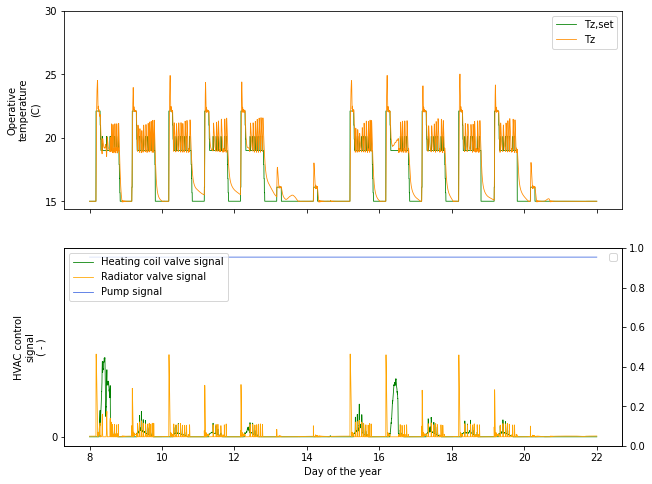

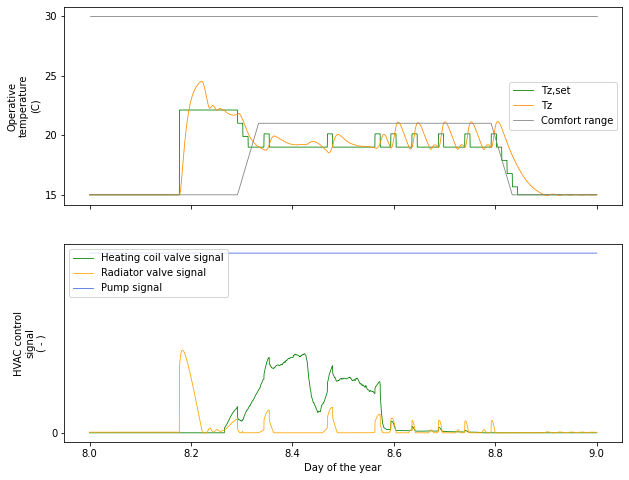

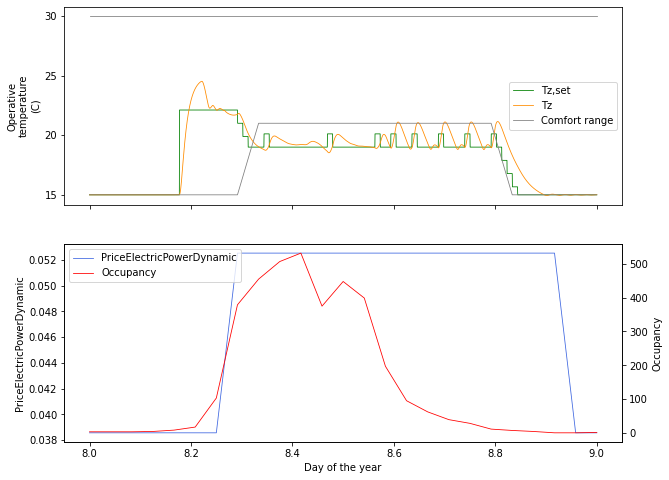

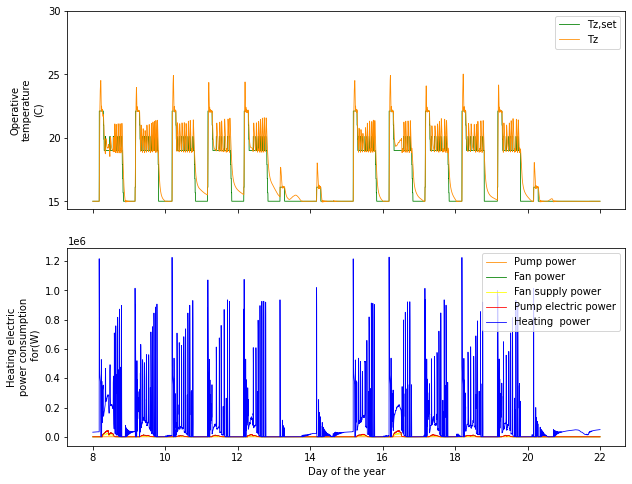

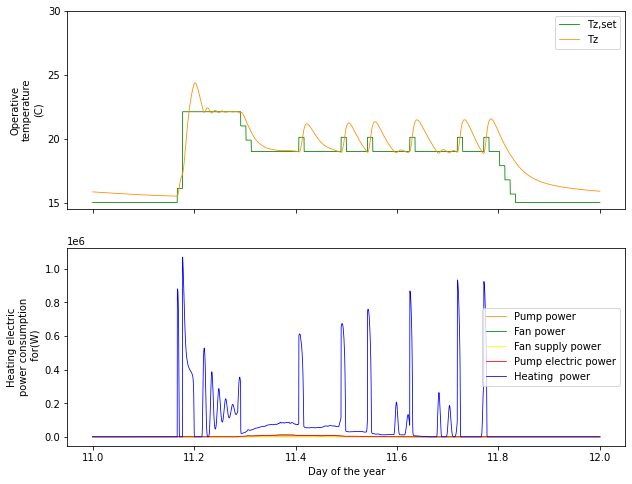

{'tdis_tot': 138.60982035567133, 'idis_tot': 5.423391263349883, 'ener_tot': 3.1704196419141266, 'cost_tot': 0.2593311924284998, 'emis_tot': 0.37821660774908483, 'pele_tot': 0.004907768737180875, 'pgas_tot': None, 'pdih_tot': 0.09321992275371412, 'time_rat': 0.003293513430587913}


In [16]:

#Print control results
# For the scenario period 
get_and_plot_results_scenario(testid, start_time=start_time_days*24*3600, final_time=np.inf)
# For a single day
get_and_plot_results_single_day(testid, start_time=start_time_days*24*3600, final_time=start_time_days*24*3600 + 24*3600, df_f_single_day = df_f_single_day)

# For a single day price
get_and_plot_results_single_day_price_occ(testid, start_time=start_time_days*24*3600, final_time=start_time_days*24*3600 + 24*3600, df_f_single_day = df_f_single_day)

# %% (optional)
# Print control demand results
# For the scenario period 
get_and_plot_demand_results(testid, start_time=start_time_days*24*3600, final_time=np.inf)
# For a single day
get_and_plot_demand_results(testid, start_time=start_time_days*24*3600 + 24*3600*3, final_time=start_time_days*24*3600 + 24*3600*4)

# %%
# Get and print the test control KPIs
kpis_con = requests.get('{0}/kpi/{1}'.format(url, testid)).json()['payload']
print(kpis_con)


### Stopping the Test 
We can stop the test case instance in order to free up web-service resources for other test cases. 

In [17]:
# Set to true if want to stop test case
stop = False
if stop:
  requests.put('{0}/stop/{1}'.format(url, testid))
